In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api
import pickle

from datetime import datetime

## Load speakers dataset

In [2]:
speakers = pd.read_json('data/df_endgame_topic_emotion.jsonl')

## Fix nationality, gender and occupation 

In [3]:
download_nationalities = False # download the label of the country from wikidata, use false if 
                               # nationalities.pickle is generated


In [4]:
nationality_id_to_nationality = {}
if download_nationalities:
    length = len(speakers.nationality.unique())
    for i, country_encoded in enumerate(speakers.nationality.unique()):
        if i % 50 == 0:
            print((i/length) * 100, "%" )
        if country_encoded not in id_to_nationalities:
            try:
                val = get_entity_dict_from_api(country_encoded)
                nationality_id_to_nationality[country_encoded] = val['labels']['en']['value']
            except:
                print(val['labels'])


    with open('nationalities.pickle', 'wb') as handle:
        pickle.dump(nationality_id_to_nationality, handle)
else:
    with open('nationalities.pickle', 'rb') as handle:
        nationality_id_to_nationality = pickle.load(handle)

#### load dataframe with wordnet conversions of the occupations

In [5]:
speakers_8_occupations = pd.read_json('data/speakers_8_occupations', compression='bz2')
speakers_8_only_scores = speakers_8_occupations.drop(columns=['n_quotes', 'n_unique_quotes', 'age', 'nationality', 'gender', 'occupation'])
speakers_8_only_scores = speakers_8_only_scores.rename({'politician_score': 'politician', 
                                    'athlete_score': 'athlete',
                                   'actor_score': 'actor',
                                   'lawyer_score': 'lawyer',
                                    'researcher_score': 'researcher',
                                    'journalist_score': 'journalist',
                                    'musician_score': 'musician',
                                    'businessperson_score': 'businessperson'
                                    }, axis=1)
id_to_occupation = speakers_8_only_scores.idxmax(axis=1)

#### Convert nationality, occupation and gender from id to real value

In [6]:
speakers.nationality = speakers.nationality.apply(
    lambda x: nationality_id_to_nationality[x] if x in nationality_id_to_nationality else 'unk')

speakers.occupation = speakers.index.map(
    lambda x: id_to_occupation[x] if x in id_to_occupation else 'unk')

genders = {'Q6581097': 'male',
           'Q6581072': 'female'
          }
speakers.gender = speakers.gender.apply(lambda x: genders[x] if x in genders else 'other')

## Clean the data

In [7]:
speakers = speakers.drop(columns=['numOccurrences', 'quotation', 'n_unique_quotes'])
speakers = speakers.dropna(axis=0) # remove row if any column value is None
speakers.head()

,n_quotes,age,nationality,gender,occupation,topic,emotion
Q233981,1773,33,South Africa,female,politician,art,joy
Q216816,1056,46,Spain,male,athlete,sport,anger
Q51685552,540,42,United States of America,male,musician,sport,joy
Q7790863,21,85,United States of America,male,politician,economy & finance,fear
Q5534345,1752,52,Australia,male,athlete,sport,neutral


#### Convert labels to categorical features

In [8]:
# This could probably be done in tensorflow instead
def convert_n_quotes_to_categorical(x):
    if 0 <= x < 10:
        return 0
    if 10 <= x < 100:
        return 1
    if 100 <= x < 500:
        return 2
    if 500 <= x < 1000:
        return 3
    return 4
speakers.n_quotes = speakers.n_quotes.apply(convert_n_quotes_to_categorical)

#### Make all text features lowercase for consistency

In [9]:
speakers.nationality = speakers.nationality.apply(lambda x: x.lower())
speakers.gender = speakers.gender.apply(lambda x: x.lower()) 
speakers.occupation = speakers.occupation.apply(lambda x: x.lower()) 
speakers.topic = speakers.topic.apply(lambda x: x.lower()) 
speakers.emotion = speakers.emotion.apply(lambda x: x.lower()) 

#### Create label encoder (onehot) for the labels

In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(speakers.n_quotes)

LabelEncoder()

#### Create feature layer

In [11]:
feature_columns = []
bucketized_column_names = [('age', list(range(5, 100, 5)))]
for col_name, boundaries in bucketized_column_names:
    numerical_clumn = tf.feature_column.numeric_column(col_name, dtype=tf.dtypes.int32, normalizer_fn=None)
    bucketized_column = feature_column.bucketized_column(numerical_clumn, boundaries=boundaries)
    feature_columns.append(bucketized_column)
indicator_column_names = ['nationality', 'gender', 'occupation', 'emotion', 'topic']

for col_name in indicator_column_names:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, speakers[col_name].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)  

#### Split into data into train, validation and test

In [12]:
train, test = train_test_split(speakers, test_size = .2 )
train, val = train_test_split(train, test_size = .2 )

#### batchify and encode dataset

In [13]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    encoded_Y = encoder.transform(dataframe.pop('n_quotes'))
    labels = np_utils.to_categorical(encoded_Y)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

#### Create, train and test the model

In [30]:
from keras import backend as K
from keras import losses

def OCC_loss(y_true, y_pred):
    '''
    Credit to https://github.com/JHart96 for this ordinal categorical crossentropy function
    '''
    weights = K.cast(K.abs(K.argmax(y_true, axis=1) - K.argmax(y_pred, axis=1))/(K.int_shape(y_pred)[1] - 1), dtype='float32')
    return (1.0 + weights) * losses.categorical_crossentropy(y_true, y_pred)

def get_model():

    model = tf.keras.Sequential([
        feature_layer,
        layers.Dense(128, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(5, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = get_model()

model.fit(train_ds,
      validation_data=val_ds,
      epochs=5)

loss, accuracy = model.evaluate(test_ds)

print("Accuracy: ", accuracy)

Epoch 1/5
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
3829/3836 [============================>.] - ETA: 0s - loss: 1.2519 - accuracy: 0.5162WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'age': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=int64>, 'nationality': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=string>, 'gender': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'occupation': <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=string>, 'topic': <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=string>, 'emotion': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=string>}
Consider rewriting this model with the Functional API.
3836/3836 [==============================] - 9s 2ms/step - loss: 1.2519 - accuracy: 0.5163 - val_loss: 1.2488 - val_accuracy: 0.5178
Epoch 2/5
3836/3836 [==============================] 

#### Prediction example

In [31]:
age = 55
nationality = 'united states of america'
gender = 'male'
occupation = 'politician'
topic = 'politics'
emotion = 'anger'

input_example = {'age': tf.convert_to_tensor([np.array(age)]),
     'nationality': tf.convert_to_tensor([np.array(nationality)]),
     'gender': tf.convert_to_tensor([np.array(gender)]), 
     'occupation': tf.convert_to_tensor([np.array(occupation)]) ,
     'topic': tf.convert_to_tensor([np.array(topic)]),
     'emotion': tf.convert_to_tensor([np.array(emotion)]),
     
    }

pred = model.predict(input_example)
print(pred)
print(np.argmax(tf.nn.softmax(pred), axis=1))

Consider rewriting this model with the Functional API.
[[0.02251375 0.25645047 0.27099028 0.13448538 0.31556016]]
[4]


Consider rewriting this model with the Functional API.


(array([1.1000e+01, 0.0000e+00, 3.7768e+04, 0.0000e+00, 0.0000e+00,
        2.2100e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5600e+02]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

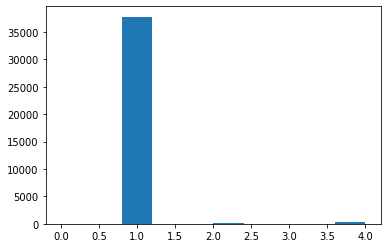

In [19]:
import matplotlib.pyplot as plt

predictions = model.predict(test_ds)
a = np.argmax(tf.nn.softmax(predictions), axis=1)

plt.hist(a)

#### Retrain on entire dataset

In [20]:
entire_df = df_to_dataset(speakers, batch_size=32)
model.fit(entire_df, epochs=10)

Epoch 1/10
5994/5994 [==============================] - 11s 2ms/step - loss: 1.5723 - accuracy: 0.5170
Epoch 2/10
5994/5994 [==============================] - 11s 2ms/step - loss: 1.5655 - accuracy: 0.5169
Epoch 3/10
5994/5994 [==============================] - 11s 2ms/step - loss: 1.5576 - accuracy: 0.5162
Epoch 4/10
5994/5994 [==============================] - 11s 2ms/step - loss: 1.5486 - accuracy: 0.5168
Epoch 5/10
5994/5994 [==============================] - 11s 2ms/step - loss: 1.5392 - accuracy: 0.5176
Epoch 6/10
5994/5994 [==============================] - 11s 2ms/step - loss: 1.5289 - accuracy: 0.5189
Epoch 7/10
5994/5994 [==============================] - 11s 2ms/step - loss: 1.5187 - accuracy: 0.5203
Epoch 8/10
5994/5994 [==============================] - 11s 2ms/step - loss: 1.5077 - accuracy: 0.5219
Epoch 9/10
5994/5994 [==============================] - 11s 2ms/step - loss: 1.4968 - accuracy: 0.5235
Epoch 10/10
5994/5994 [==============================] - 12s 2ms/step - l

#### Save model

In [32]:
model.save('models/quote_prediction_model')

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
INFO:tensorflow:Assets written to: models/quote_prediction_model/assets


#### Test loading the model


In [33]:
new_model = tf.keras.models.load_model('models/quote_prediction_model')

age = 55
nationality = 'united states of america'
gender = 'male'
occupation = 'politician'
topic = 'politics'
emotion = 'anger'

input_example = {'age': tf.convert_to_tensor([np.array(age)]),
     'nationality': tf.convert_to_tensor([np.array(nationality)]),
     'gender': tf.convert_to_tensor([np.array(gender)]), 
     'occupation': tf.convert_to_tensor([np.array(occupation)]) ,
     'topic': tf.convert_to_tensor([np.array(topic)]),
     'emotion': tf.convert_to_tensor([np.array(emotion)]),
     
    }

pred = new_model.predict(input_example)
print(pred)
print(np.argmax(tf.nn.softmax(pred), axis=1))

Consider rewriting this model with the Functional API.
[[0.02251375 0.25645047 0.27099028 0.13448538 0.31556016]]
[4]
